In [1]:
import os
import cv2 # needed to create movie visualization of optimizaiton
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
import imageio
import torch
import torch.distributions as dist

from pybpl.library import Library
from pybpl.model import CharacterModel
from pybpl.objects.concept import CharacterType
from pybpl.objects.part import StrokeType
from pybpl.objects.relation import RelationIndependent, RelationAttachAlong
from pybpl import rendering

In [2]:
# library and type distribution
lib = Library('../lib_data/')
model = CharacterModel(lib)

In [3]:
# for better image visualization in matplotlib
def box_only(obj):
    obj.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

## first, load the target image

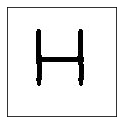

In [4]:
img_target = imageio.imread('./image_H.jpg')
img_target = np.asarray(img_target, dtype=np.float32) / 255.
plt.figure(figsize=(2,2))
plt.imshow(img_target, cmap='Greys')
box_only(plt)
plt.show()

## Now, create an initial "H" type and token that we will optimize

In [5]:
def initial_H_type():
    # first stroke has 1 sub-stroke, with id "0"
    s1 = StrokeType(
        nsub=torch.tensor(1), 
        ids=torch.tensor([0]),
        shapes=lib.shape['mu'][0].view(5, 2, 1),
        invscales=torch.tensor([0.5])
    )
    r1 = RelationIndependent(
        category='unihist',
        #gpos=torch.tensor([30., -22.]),
        gpos=torch.tensor([32., -20.]),
        xlim=lib.Spatial.xlim,
        ylim=lib.Spatial.ylim,
    )
    # second stroke has 1 sub-stroke, with id "9"
    s2 = StrokeType(
        nsub=torch.tensor(1), 
        ids=torch.tensor([9]),
        shapes=lib.shape['mu'][9].view(5, 2, 1),
        invscales=torch.tensor([0.4])
    )
    r2 = RelationAttachAlong(
        category='mid',
        attach_ix=torch.tensor(0),
        attach_subix=torch.tensor(0),
        eval_spot=torch.tensor(4.5),
        ncpt=lib.ncpt
    )
    # third stroke has 1 sub-stroke, with id "0"
    s3 = StrokeType(
        nsub=torch.tensor(1), 
        ids=torch.tensor([0]),
        shapes=lib.shape['mu'][0].view(5, 2, 1),
        invscales=torch.tensor([0.5])
    )
    r3 = RelationIndependent(
        category='unihist',
        #gpos=torch.tensor([70., -22.]),
        gpos=torch.tensor([68., -20.]),
        xlim=lib.Spatial.xlim,
        ylim=lib.Spatial.ylim
    )
    k = torch.tensor(3)
    P = [s1, s2, s3]
    R = [r1, r2, r3]
    # initialize the type
    ctype = CharacterType(k, P, R)
    
    return ctype

In [6]:
ctype = initial_H_type()
ctoken = model.sample_token(ctype)
# get optimizable parameters
params = ctype.parameters() + ctoken.parameters()
lbs = ctype.lbs() + ctoken.lbs()
ubs = ctype.ubs() + ctoken.ubs()
# set requires_grad to True for asll parameters
ctype.train()
ctoken.train()

In [7]:
# set large blur value to make learning easier
ctoken.blur_sigma = torch.tensor(
    10., dtype=torch.float, requires_grad=True
)

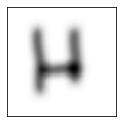

In [8]:
pimg = model.get_pimg(ctoken)
plt.figure(figsize=(2,2))
plt.imshow(pimg.detach().numpy(), cmap='Greys')
box_only(plt)
plt.show()

### optimize

In [16]:
vid = 'video.mov'
if os.path.exists(vid):
    os.remove(vid)
video = cv2.VideoWriter(vid,-1,10,(105,105))
nb_iter = 300
interval = 5 # how often we will log pimg status
lr = 4e-3
img_target = torch.tensor(img_target)

score_type_list = [] 
score_token_list = []
score_img_list = []
imgs = []
optimizer = torch.optim.Adam(params, lr=lr)
torch.autograd.set_detect_anomaly(True)
for idx in tqdm(range(nb_iter)):
    if idx % interval == 0:
        # store pimg at this iteration for later viewing
        pimg = model.get_pimg(ctoken)
        pimg = pimg.detach().numpy()
        pimg = np.stack([pimg, pimg, pimg], axis=2)
        pimg = np.asarray(pimg*255., dtype=np.uint8)
        imgs.append(pimg) #append images
        #video.write(np.copy(pimg))
    # compute scores
    score_type = model.score_type(ctype)
    score_token = model.score_token(ctype, ctoken)
    score_img = model.score_image(ctoken, img_target)
    
    score = score_type + score_token + score_img
    # append to lists
    score_type_list.append(score_type.detach().numpy())
    score_token_list.append(score_token.detach().numpy())
    score_img_list.append(score_img.detach().numpy())
    # first, zero all gradients
    optimizer.zero_grad()
    # now, perform backward pass
    score_neg = -score
    score_neg.backward()
    # optimization step
    optimizer.step()
    # clip params at boundaries
    with torch.no_grad():
        for ip, param in enumerate(params):
            lb = lbs[ip]
            ub = ubs[ip]
            #if lb is not None:
            #    torch.max(param, lb, out=param)
            #if ub is not None: 
            #    torch.min(param, ub, out=param)
                
cv2.destroyAllWindows()
video.release()

/Users/qdo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100%|██████████| 300/300 [01:59<00:00,  2.51it/s]


### check loss vs iteration

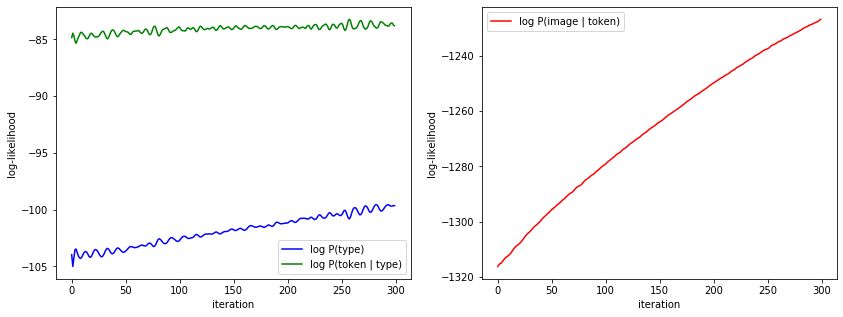

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
# type and token scores
axes[0].plot(score_type_list, c='b', label='log P(type)')
axes[0].plot(score_token_list, c='g', label='log P(token | type)')
axes[0].set_ylabel('log-likelihood')
axes[0].set_xlabel('iteration')
axes[0].legend()
# image score
axes[1].plot(score_img_list, c='r', label='log P(image | token)')
axes[1].set_ylabel('log-likelihood')
axes[1].set_xlabel('iteration')
axes[1].legend()
plt.show()

### check pimg vs iteration

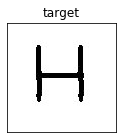

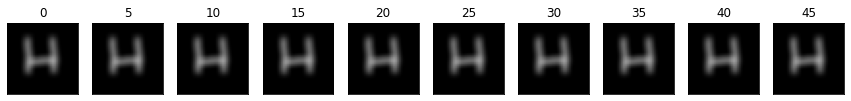

In [18]:
plt.figure(figsize=(2,2))
plt.imshow(img_target, cmap='Greys')
box_only(plt)
plt.title('target')
plt.show()
print('')

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(imgs[i], cmap='Greys')
    box_only(axes[i])
    axes[i].set_title('%i' % (interval*i))
plt.show()